In [1]:
from swemnics.problems import TidalProblem
from swemnics import solvers as Solvers
from mpi4py import MPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dolfinx import fem as fe
from tqdm import tqdm

import pandas as pd
from scipy.optimize import minimize
import seaborn as sns 
from typing import Callable, Dict, List, Tuple, Any, Union

from plotting import plot_simulation_results, create_comparison_figure
from fourd_var import*
from dca_utils import*

sns.set_palette("bright")
plt.style.use("mystyle1.mplstyle")

In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()


problem_params = {
    'nx': 20,
    'ny': 5,
    'dt': 3600,
    't': 0,
    't_final': 7*24*60*60, # 7 days 
    'num_steps': int(np.ceil((7*24*60*60)/3600)),
    'num_windows': 4,
    'fric_law': 'mannings',    #friction law either quadratic or linear
    'sol_var': 'h'             #solution variable either h or hu
}

solver_params = {"rtol": 1e-5,
          "atol": 1e-6,
          "max_it":10,
          "relaxation_parameter":1.0,
          "ksp_type": "gmres",
          "pc_type": "ilu",
          "ksp_ErrorIfNotConverged": False,
          }#,"pc_factor_mat_solver_type":"mumps"}


In [10]:
assert problem_params['num_steps'] == int(np.ceil(problem_params['t_final']/problem_params['dt']))
obs_frequency = 4  # observe system every 4th time step
true_signal, prob, stations, state_coords = get_true_signal(problem_params,
                                                            'tidal',
                                                            solver_params, 
                                                            create_problem_solver,
                                                            obs_frequency)

V scalar FunctionSpace(<Mesh #2>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
USING NONSPHERICAL WELLBALANCED
WD NONACTIVE
CF =  0.025
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
WD NONACTIVE
CF =  0.025
V_coords shape: (126, 3)
Solver object <class 'swemnics.newton.CustomNewtonProblem'> has been initialized


In [11]:
print(f"Total Dof =  H_dof x u_dof x v_dof: {true_signal.u.x.array.shape}")
print(f"Observation Frequency: {obs_frequency}")
print(f"Number of Stations x (H,u,v): {stations.shape}")
print(f"N Time Steps, N Stations, N Variables: {true_signal.vals.shape}")
print(f"Number of Adjoints Saved: {len(true_signal.saved_jacobians)}")
print(f"Adjoint Size: {true_signal.saved_jacobians[0].sizes}")
print(f"Number of states Saved: {len(true_signal.saved_states)}")
print(f"State Size: {true_signal.saved_states[0].x.array.shape}")

Total Dof =  H_dof x u_dof x v_dof: (378,)
Observation Frequency: 4
Number of Stations x (H,u,v): (32, 3)
N Time Steps, N Stations, N Variables: (169, 32, 3)
Number of Adjoints Saved: 168
Adjoint Size: ((378, 378), (378, 378))
Number of states Saved: 168
State Size: (378,)


In [28]:
obs_std=0.8
total_steps = int((problem_params['t_final']/problem_params['dt']) + 1)
problem_params['num_steps'] = int(np.ceil((7*24*60*60)/3600)/problem_params['num_windows']) # Size of each assimilation window
obs_per_window = problem_params['num_steps'] // obs_frequency 

print(f"Total Steps: {total_steps}\n"
      f"Total Assimilation Windows: {problem_params['num_windows']}\n"
      f"Steps per Window: {problem_params['num_steps']}\n"
      f"Obs Frequency: {obs_frequency}\n"
      f"Total Obs: {obs_per_window * problem_params['num_windows']}\n"
      f"Number Stations: {stations.shape[0]}\n"
      f"Obs per Window: {obs_per_window}\n")


# Create synthetic observations
obs_spatial_indices = find_obs_indices(stations, state_coords)
obs_indices_per_window, obs_time_indices = setup_observation_indices(problem_params['num_steps'], obs_frequency, total_steps)

print(f"Observation Spatial Indices: {obs_spatial_indices}\n\n"
      f"Observation Time Indices: {obs_time_indices}\n\n"
      f"Observation Time Indices per Window: {obs_indices_per_window}\n\n"
      )

hb = 10 + (stations[:, 0]*0)
y_obs = generate_observations(true_signal, hb, obs_time_indices, obs_std)


# Generate Background,Observation, and Predicted Error Covariance Matrices
state_dim = true_signal.problem.h_b.x.array.shape[0]
obs_dim = stations.shape[0]

# Observation Matrix
H = np.zeros((obs_dim, state_dim))
H[np.arange(obs_dim), obs_spatial_indices] = 1.0

# Observation Covariance 
R = np.eye(obs_dim) * (obs_std**2)

# Background Covariance 
inflation_factor=3.5
B = inflation_factor*np.eye(state_dim) 

# Predicted Covariance
P = H @ B @ H.T 

# Get Inverse Covariance matrices
R_inv = np.linalg.inv(R)
B_inv = np.linalg.inv(B) 
P_inv = np.linalg.inv(P)

print(f"State Dimension: {state_dim}\n"
      f"Observation Dimension: {obs_dim}\n"
      f"Background Covariance Matrix Shape B: {B.shape}\n"
      f"Observation Covariance Matrix Shape R: {R.shape}\n"
      f"Predicted Error Covariance Matrix shape P: {P.shape}\n"
      f"Observation Matrix Shape H: {H.shape}\n")


Total Steps: 169
Total Assimilation Windows: 4
Steps per Window: 42
Obs Frequency: 4
Total Obs: 40
Number Stations: 32
Obs per Window: 10

Observation Spatial Indices: [  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124]

Observation Time Indices: [  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140
 144 148 152 156 160 164 168]

Observation Time Indices per Window: [ 0  4  8 12 16 20 24 28 32 36 40]


State Dimension: 126
Observation Dimension: 32
Background Covariance Matrix Shape B: (126, 126)
Observation Covariance Matrix Shape R: (32, 32)
Predicted Error Covariance Matrix shape P: (32, 32)
Observation Matrix Shape H: (32, 126)



In [ ]:
def swe_adjoint(solver, V, H, obs_data, obs_spatial_idxs, obs_time_idxs, R_inv
    ) -> np.ndarray:
        """
        Solves the adjoint equation backward in time using UFL's automatic differentiation.

        Parameters:
            solver: Solver object containing the forward problem solution and adjoint forms
            V: Function space
            H: Observation operator
            obs_time_idxs: List of observation times (indices)
            obs_data: List of np.ndarrays of observation data
            obs_spatial_idxs: DOF indices of observations
            R_inv: Inverse of observation covariance matrix
        Returns:
            grad_init: NumPy array representing ∇J(z0)
        """
        adjoints = solver.saved_jacobians   # List of adjoint forms for each time step
        trajectories = solver.saved_states     # List of states at each time step
        
        
        nt = solver.vals.shape[0] - 1  # Number of time steps
        λ = fem.Function(V)
        λ_vec = np.zeros((nt + 1, len(λ.x.array)))
        λ.x.array[:] = 0.0

        # Create functions for current and next time steps
        u_n = fem.Function(V)

        # possible that λ_nt = Initial Misfit
        for n in reversed(range(nt)):
            # Set the state at the current time step
            u_n.x.array[:] = trajectories[n].copy()

            # build rhs of the adjoint equation H^TRinv(HQ - y)
            # Add the observation term if this is an observation time
            if n in obs_time_idxs:
                idx = obs_time_idxs.index(n)
                residual = trajectories[n + 1][obs_spatial_idxs] - obs_data[idx,:]  # HQ - y 

                # Create a function to represent the observation term
                obs_func = fem.Function(V)
                obs_func.x.array[:] = 0.0
                obs_func.x.array[obs_spatial_idxs] = H.T @ R_inv @ residual

                # Add contribution to the adjoint right-hand side
                λ.x.array[:] += obs_func.x.array[:]

            # Get Rid of this code
            # L_adjoint = (1/dt) * inner(λ, v) * dx  # RHS of adjoint equation
            # problem = LinearProblem(adjoints, L_adjoint, bcs=[bc],
            #                        petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
            # λ_sol = problem.solve()

            # New code to keep ( Look at claude implementation of solvers for ks and burgers for the solves)
            # Solve the adjoint problem Rylan todo: (use ksp) in Custom_Newton
            # Update adjoint variable
            # λ_sol  =  ksp.solve(a_adjoints[n], λ.x.array[:])
            
            λ.x.array[:] = λ_sol.x.array[:]
            λ_vec[n, :] = λ.x.array.copy()

        return λ_vec[0, :]

In [31]:
obs_per_window

10

In [44]:
y_obs.shape

(43, 32)

In [32]:
obs_indices_per_window

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40])

In [37]:
obs_time_indices[:obs_per_window]

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])

In [43]:
for i in range(problem_params['num_windows']):
        start = i * obs_per_window
        end = start + obs_per_window
        print(obs_time_indices[start:end])
        print(f"Window {i}: Observations from time steps {start} to {end}")
        indices = np.arange(obs_per_window) + (i * obs_per_window)
        print(f"Observation Indices for Window {i}: {indices}")

    
    # Save or process the gradient as needed

[ 0  4  8 12 16 20 24 28 32 36]
Window 0: Observations from time steps 0 to 10
Observation Indices for Window 0: [0 1 2 3 4 5 6 7 8 9]
[40 44 48 52 56 60 64 68 72 76]
Window 1: Observations from time steps 10 to 20
Observation Indices for Window 1: [10 11 12 13 14 15 16 17 18 19]
[ 80  84  88  92  96 100 104 108 112 116]
Window 2: Observations from time steps 20 to 30
Observation Indices for Window 2: [20 21 22 23 24 25 26 27 28 29]
[120 124 128 132 136 140 144 148 152 156]
Window 3: Observations from time steps 30 to 40
Observation Indices for Window 3: [30 31 32 33 34 35 36 37 38 39]


In [40]:
y_obs.shape

(43, 32)

In [ ]:
bayes_analysis = run_assimilation(problem_params,
                                  solver_params,
                                  stations,
                                  y_obs,
                                  obs_per_window,
                                  obs_time_indices
                                  H, B_inv, R_inv, P_inv, hb,
                                'tidal',
                                create_problem_solver,
                                bayes_cost_function,
                                swe_adjoint
                             )

Processing windows:   0%|          | 0/4 [00:00<?, ?window/s]

V scalar FunctionSpace(<Mesh #1>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
USING NONSPHERICAL WELLBALANCED
Solver Time 1: 0
Iteration 1: Cost = 19.043767
Iteration 2: Cost = 18.470399


Processing windows:   0%|          | 0/4 [08:48<?, ?window/s]


KeyboardInterrupt: 

In [ ]:
# bayes_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              bayes_cost_function,
#                              grad_bayes_cost_function
#                              )

In [ ]:
# dci_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              dci_cost_function, 
#                             grad_dci_cost_function
#                              )

In [ ]:
# dci_wme_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              dci_wme_cost_function,
#                              grad_dci_wme_cost_function
#                              )

In [ ]:
print(true_signal.vals.shape, bayes_analysis.shape, y_obs.shape)
print(true_signal.vals[obs_indices].shape, bayes_analysis[obs_indices].shape)

(169, 32, 3) (169, 32, 3) (43, 32)
(43, 32, 3) (43, 32, 3)


In [ ]:
# bayes_analysis
# dci_analysis

In [10]:
bayes_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - bayes_analysis[:,:,0]) ** 2))
bayes_rmse

np.float64(0.00017012346675273124)

In [14]:
bayes_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - bayes_analysis[:,:,0]) ** 2)) 
bayes_rmse

np.float64(0.00016845774408423133)

In [16]:
bayes_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - bayes_analysis[:,:,0]) ** 2)) 
bayes_rmse

np.float64(0.0001684577440840877)

In [16]:
dci_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - dci_analysis[:,:,0]) ** 2))
dci_rmse

np.float64(0.0001684577440841142)

In [ ]:
dci_wme_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - dci_wme_analysis[:,:,0]) ** 2))
dci_wme_rmse

In [ ]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 45,
    "legend.frameon": False,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "axes.labelsize": 45,
    "axes.labelpad": 10,
    "axes.titlesize": 45,
    "figure.figsize": (44, 16),
}


plot_simulation_results(true_signal, bayes_analysis, y_obs, hb, problem_params,
                       obs_indices, plot_params, save=False, save_prefix="bayes_")

In [ ]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 45,
    "legend.frameon": False,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "axes.labelsize": 45,
    "axes.labelpad": 10,
    "axes.titlesize": 45,
    "figure.figsize": (44, 16),
}


plot_simulation_results(true_signal, bayes_analysis, y_obs, hb, problem_params,
                       obs_indices, plot_params, save=False, save_prefix="bayes_")

In [ ]:
filenames = ["wse", "xvel", "yvel"]

for i, filename in enumerate(filenames):
	with open(f"{name}_p1_{filename}.pkl", 'wb') as f:
		pickle.dump(solver.vals[:,:,i], f)

# np.savetxt(f"{name}_p1_wse.csv", solver.vals[:,:,0], delimiter=",")
# np.savetxt(f"{name}_p1_xvel.csv", solver.vals[:,:,1], delimiter=",")
# np.savetxt(f"{name}_p1_yvel.csv", solver.vals[:,:,2], delimiter=",")

----
# Expiremental

In [8]:
from scipy.optimize import approx_fprime
import numpy as np


In [ ]:
# bayes_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              bayes_cost_function,
#                              grad_bayes_cost_function
#                              )

In [9]:
# load initial state .npy file 
z0 = np.load("initial_state.npy")
zb = np.load("initial_state.npy") 
Qzb = np.load("backgroundQzb.npy")

idx= 0
initial_time = int(idx * problem_params["num_steps"] * problem_params["dt"])
problem_params.update({"t": initial_time})

# Create problem and solver
_, solver = create_problem_solver(
    problem_params, 'tidal', true_signal=False
)
solver.problem.t = initial_time
indices = np.arange(obs_per_window) + (idx * obs_per_window)
yobs_current_window = y_obs[indices]


V scalar FunctionSpace(<Mesh #1>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
USING NONSPHERICAL WELLBALANCED


In [10]:
def cost_fn(z0):
    total_cost = bayes_cost_function(
        z0,
        zb,
        yobs_current_window,
        obs_indices_per_window[:-1],
        H,
        B_inv,
        R_inv,
        P_inv,
        Qzb,
        solver_params,
        stations,
        hb,
        solver,
        initial_time,
    )
    # print(f"Cost function value: {total_cost}")
    return total_cost

#get gradient for cost function 
def grad_fn(z0):
    grad = grad_bayes_cost_function(
        z0,
        zb,
        yobs_current_window,
        obs_indices_per_window[:-1],
        H,
        B_inv,
        R_inv,
        P_inv,
        Qzb,
        solver_params,
        stations,
        hb,
        solver,
        initial_time,
    )
    return grad 



def cost_function_gradient1(x0, epsilon=1e-6):
    """
    Compute the gradient of the cost function using finite differences.
    """
    # Using central finite differences
    grad = np.zeros_like(x0)
    
    for i in range(len(x0)):
        x_plus = x0.copy()
        x_minus = x0.copy()
        
        x_plus[i] += epsilon
        x_minus[i] -= epsilon
        
        J_plus = cost_fn(x_plus)
        J_minus = cost_fn(x_minus)
        
        grad[i] = (J_plus - J_minus) / (2 * epsilon)
        
    return grad

In [13]:
# grad_at_init = grad_fn(z0)
# print(f"Gradient at initial state: {grad_at_init}")

In [41]:
grad_at_init.shape

(126,)

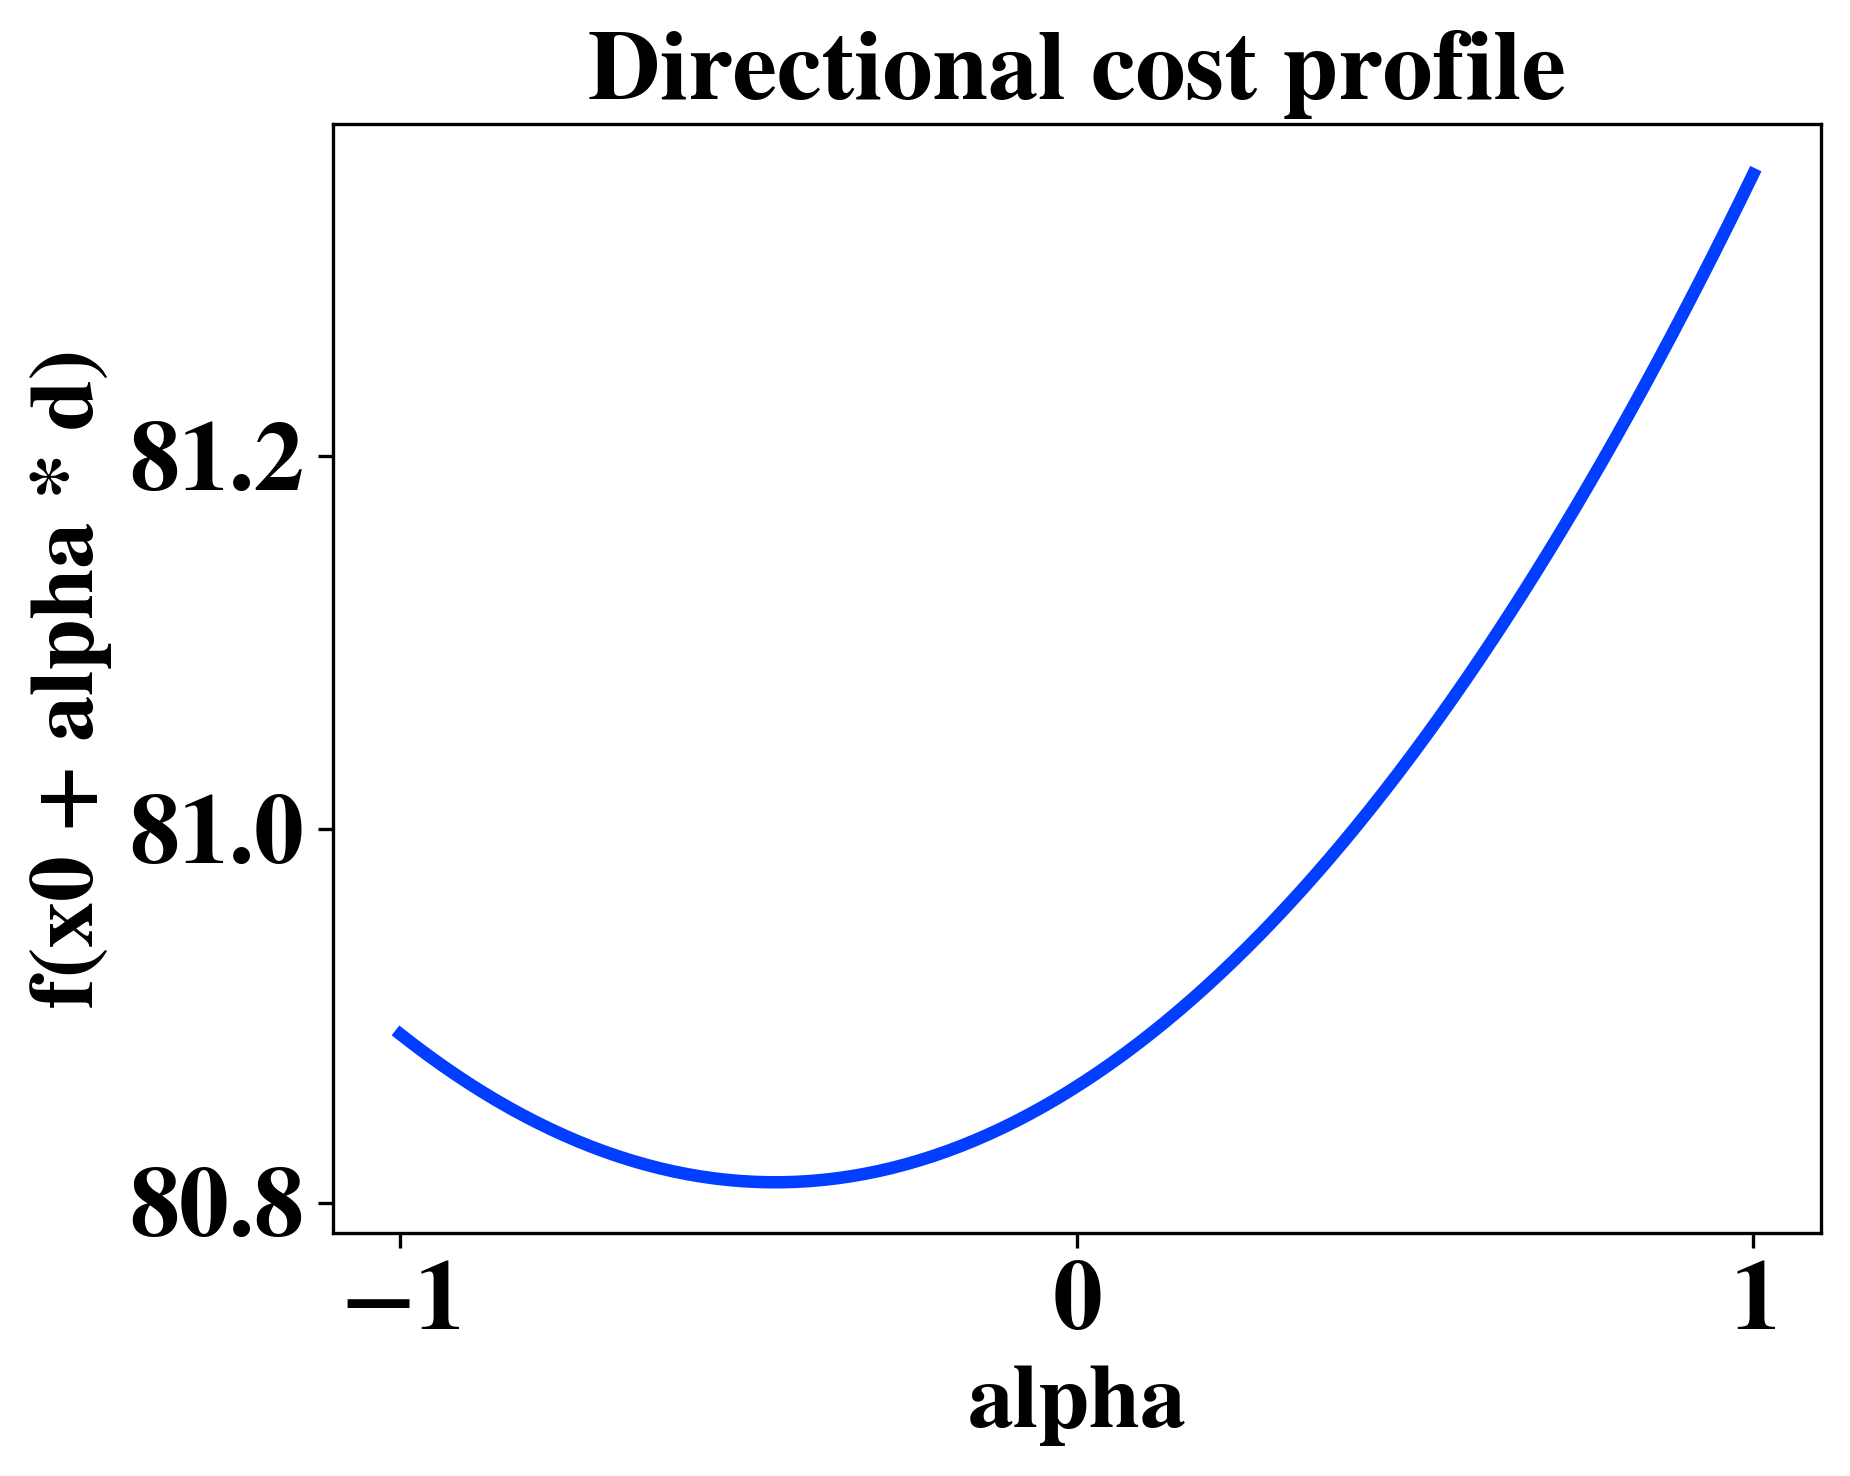

In [43]:
# direction = np.random.randn(*z0.shape)
# direction /= np.linalg.norm(direction) 
direction = -grad_at_init / np.linalg.norm(grad_at_init)
alphas = np.linspace(-1, 1, 100)
vals = []

for alpha in alphas: 
    z = z0 + alpha * direction
    cost = cost_fn(z)
    vals.append(cost)
    # print(f"Alpha: {alpha}, Cost: {cost}")


plt.plot(alphas, vals)
plt.xlabel("alpha")
plt.ylabel("f(x0 + alpha * d)")
plt.title("Directional cost profile")
plt.show()

In [45]:
def cost_function_gradient1(z0, epsilon=1e-6):
    """
    Efficient forward finite difference gradient.
    """
    z0 = np.asarray(z0)
    grad = np.empty_like(z0)
    J_base = cost_fn(z0)

    x_perturbed = z0.copy()

    for i in range(z0.size):
        old_val = x_perturbed[i]
        x_perturbed[i] = old_val + epsilon

        grad[i] = (cost_fn(x_perturbed) - J_base) / epsilon

        x_perturbed[i] = old_val  # restore in-place

    return grad


def cost_function_gradient2(z0, epsilon=1e-6):
    """
    Compute the gradient of the cost function using forward finite differences.
    """
    grad = np.empty_like(z0)
    J_base = cost_fn(z0)

    x_perturbed = z0.copy()

    for i in range(len(z0)):
        x_perturbed[i] = z0[i] + epsilon
        J_plus = cost_fn(x_perturbed)
        grad[i] = (J_plus - J_base) / epsilon
        x_perturbed[i] = z0[i]  # Reset to original value

    return grad


def cost_function_gradient3(z0, epsilon=1e-6):
    """
    Optimized forward finite difference gradient using vectorization.
    """
    z0 = np.asarray(z0)
    n = z0.size
    J_base = cost_fn(z0)
    
    # Create a matrix where each row is z0 with one element perturbed
    perturbations = np.eye(n) * epsilon
    z_perturbed = z0.reshape(1, -1) + perturbations
    
    # Compute all perturbed cost function values at once
    J_perturbed = np.array([cost_fn(z) for z in z_perturbed])
    
    # Calculate all gradients at once
    grad = (J_perturbed - J_base) / epsilon
    
    return grad 


def cost_function_gradient4(z0, epsilon=1e-6, batch_size=5):
    """
    Batched forward finite difference gradient for large arrays.
    """
    z0 = np.asarray(z0)
    n = z0.size
    J_base = cost_fn(z0)
    grad = np.empty(n)
    
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        batch_size_actual = end - i
        
        # Create batch of perturbations
        perturbations = np.eye(batch_size_actual) * epsilon
        z_batch = np.tile(z0, (batch_size_actual, 1))
        z_batch[:, i:end] += perturbations
        
        # Compute batch of cost function values
        J_perturbed = np.array([cost_fn(z) for z in z_batch])
        
        # Calculate batch of gradients
        grad[i:end] = (J_perturbed - J_base) / epsilon
        
    return grad

In [15]:

epsilon = np.sqrt(np.finfo(float).eps)  # ≈ 1.49e-8
# Analytic gradient
grad_analytic = cost_function_gradient1(z0)

# Numerical gradient via forward finite differences
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

error = np.linalg.norm(grad_analytic - grad_numerical)
rel_error = error / (np.linalg.norm(grad_numerical) + 1e-12)

print("Gradient error:", error)
print("Relative error:", rel_error)


Gradient error: 1.024021508113475e-05
Relative error: 7.2117852941048715e-06


In [22]:

epsilon = np.sqrt(np.finfo(float).eps)  # ≈ 1.49e-8
# Analytic gradient
grad_analytic = cost_function_gradient4(z0)

# Numerical gradient via forward finite differences
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

error = np.linalg.norm(grad_analytic - grad_numerical)
rel_error = error / (np.linalg.norm(grad_numerical) + 1e-12)

print("Gradient error:", error)
print("Relative error:", rel_error)


Gradient error: 4.615039961807716e-06
Relative error: 1.2891154315753199e-06


In [20]:
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

In [30]:
grad_analytic1 = cost_function_gradient1(z0,epsilon)

In [ ]:
grad_analytic2 = cost_function_gradient2(z0,epsilon)

In [35]:
grad_analytic3 = cost_function_gradient3(z0,epsilon)

In [46]:
grad_analytic4 = cost_function_gradient4(z0,epsilon)